In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/veggies-dataset/Data Veges/USD_PKR Historical Data.csv
/kaggle/input/veggies-dataset/Data Veges/Petrol Price.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Dera Ghazi Khan.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Patoki.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Nankana Sahib.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Kamalia.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Mandi Bahauddin.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Lahore.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Burewala.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Abdulhakim.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Kassowal.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/Quaidabad.csv
/kaggle/input/veggies-dataset/Data Veges/weather data/We

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn#neural network
import torch.nn.functional as F#
import torch.optim as optim#
import gc#
import warnings#
warnings.filterwarnings('ignore')#filterwarnings()。

import random
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True#
    torch.backends.cudnn.benchmark = False#，
    torch.manual_seed(seed)#
    np.random.seed(seed)#
    random.seed(seed)#
seed_everything(seed=2024)

In [3]:
import pandas as pd
df_cap = pd.read_csv('/kaggle/input/veggies-dataset/Data Veges/Vegetable Data/YearMonthWiseReport-Onion.csv')
df_usd = pd.read_csv('/kaggle/input/veggies-dataset/Data Veges/USD_PKR Historical Data.csv')
df_petrol = pd.read_csv('/kaggle/input/veggies-dataset/Data Veges/Petrol Price.csv')

In [4]:
df_cap['y'] = df_cap['textbox2'].str.replace(',', '').astype(float)
df_cap['Date'] =pd.to_datetime(df_cap['Date'])
df_cap['unique_id'] =df_cap['textbox3'].str.split(' ').str[0]
min_date = df_cap['Date'].min()
max_date = df_cap['Date'].max()
city_counts = df_cap['unique_id'].value_counts()
print(city_counts)
print(df_cap.info(), min_date, max_date)

unique_id
Vehari              1849
Lodhran             1797
Multan              1742
Summandri           1741
Khanewal            1717
                    ... 
Shahjewana           101
Sukheke               95
Khairpurtamewali      35
ChuaSaidanShah         1
Karachi                1
Name: count, Length: 135, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134692 entries, 0 to 134691
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   textbox3      134692 non-null  object        
 1   Month         134692 non-null  object        
 2   Year          134692 non-null  object        
 3   Date          134692 non-null  datetime64[ns]
 4   CropNameUrdu  134692 non-null  object        
 5   textbox2      134692 non-null  object        
 6   y             134692 non-null  float64       
 7   unique_id     134692 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory 

In [5]:
valid_cities = city_counts[city_counts > 1500].index

# Filter df_cap to keep only rows with these cities
df_cap_filtered = df_cap[df_cap['unique_id'].isin(valid_cities)]

In [6]:
cities = df_cap_filtered['unique_id'].unique().tolist()


In [7]:
# Create a date range
Date = pd.date_range(min_date, max_date)

# Repeat the date range 10 times
ds_values = Date.repeat(len(cities))

# Create the DataFrame
df_final = pd.DataFrame({
    'ds': ds_values
})

# Display the result
print(df_final['ds'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 51675 entries, 0 to 51674
Series name: ds
Non-Null Count  Dtype         
--------------  -----         
51675 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 403.8 KB
None


In [8]:
repeated_cities = np.tile(cities, len(df_final) // len(cities) + 1)[:len(df_final)]

# Fill the unique_id column with the repeated city names
df_final['unique_id'] = repeated_cities

In [9]:
df_final = pd.merge(
    df_final, 
    df_cap[['Date', 'unique_id', 'y']],  # Use 'Date' from df_final
    left_on=['ds', 'unique_id'],  # Match 'ds' from merged_df with 'Date' and 'unique_id'
    right_on=['Date', 'unique_id'], 
    how='left'
)

# Drop the redundant 'Date' column from the merge
df_final.drop(columns=['Date'], inplace=True)

# Display the result
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51675 entries, 0 to 51674
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         51675 non-null  datetime64[ns]
 1   unique_id  51675 non-null  object        
 2   y          41292 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB
None


In [10]:
# Ensure the DataFrame is sorted by 'unique_id' and 'ds' (important for time-based interpolation)
df_final = df_final.sort_values(by=['unique_id', 'ds'])

# Apply interpolation to 'y' separately for each 'unique_id'
df_final['y'] = (
    df_final.groupby('unique_id')['y']
    .apply(lambda group: group.interpolate(method="linear", limit_direction="both"))
    .reset_index(level=0, drop=True)  # Reset the index to align with the original DataFrame
)

# Display the resulting DataFrame information
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 51675 entries, 10 to 51673
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         51675 non-null  datetime64[ns]
 1   unique_id  51675 non-null  object        
 2   y          51675 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.6+ MB
None


In [11]:
print(df_usd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2679 non-null   object 
 1   Price     2679 non-null   float64
 2   Open      2679 non-null   float64
 3   High      2679 non-null   float64
 4   Low       2679 non-null   float64
 5   Vol.      1055 non-null   object 
 6   Change %  2679 non-null   object 
dtypes: float64(4), object(3)
memory usage: 146.6+ KB
None


In [12]:
df_usd['Date'] = pd.to_datetime(df_usd['Date'], errors='coerce')
df_final = pd.merge(df_final, df_usd[['Date', 'Price']], how='left', left_on='ds', right_on='Date')
df_final['Price'] = df_final.groupby('unique_id')['Price'].ffill().bfill()

In [13]:

print(df_petrol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Period End  506 non-null    object
 1   Islamabad   506 non-null    object
 2   Rawalpindi  506 non-null    object
 3   Gujranwala  506 non-null    object
 4   Sialkot     506 non-null    object
 5   Lahore      506 non-null    object
 6   Faisalabad  506 non-null    object
 7   Sargodha    506 non-null    object
 8   Multan      506 non-null    object
 9   Bahawalpur  506 non-null    object
 10  Karachi     506 non-null    object
 11  Hyderabad   506 non-null    object
 12  Sukkur      506 non-null    object
 13  Larkana     506 non-null    object
 14  Peshawar    506 non-null    object
 15  Bannu       506 non-null    object
 16  Quetta      506 non-null    object
 17  Khuzdar     506 non-null    object
 18  Pakistan    506 non-null    object
dtypes: object(19)
memory usage: 75.2+ KB
None


In [14]:
df_final = df_final.sort_values(by=['unique_id', 'ds'])
df_petrol['Period End'] = pd.to_datetime(df_petrol['Period End'], errors='coerce')
df_final = pd.merge(df_final, df_petrol[['Period End', 'Pakistan']], how='left', left_on='ds', right_on='Period End')
df_final['Pakistan'] = df_final.groupby('unique_id')['Pakistan'].ffill().bfill()

In [15]:
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51675 entries, 0 to 51674
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          51675 non-null  datetime64[ns]
 1   unique_id   51675 non-null  object        
 2   y           51675 non-null  float64       
 3   Date        44450 non-null  datetime64[ns]
 4   Price       51675 non-null  float64       
 5   Period End  6625 non-null   datetime64[ns]
 6   Pakistan    51675 non-null  object        
dtypes: datetime64[ns](3), float64(2), object(2)
memory usage: 2.8+ MB
None


In [16]:
import os
import pandas as pd

# Define the directory path and file extension
data_dir = '/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data'
file_ext = '.csv'  # Assuming CSV files

# Get the first 10 file names
file_names = sorted(os.listdir(data_dir))

In [17]:
check = pd.read_csv('/kaggle/input/veggies-dataset/Data Veges/weather data/Weather Data/AhmadPurEast.csv')
print(check['conditions'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 1779 entries, 0 to 1778
Series name: conditions
Non-Null Count  Dtype 
--------------  ----- 
1779 non-null   object
dtypes: object(1)
memory usage: 14.0+ KB
None


In [18]:
import os
import pandas as pd

def process_dataset(file_names, df_final, data_dir):
    merged_df = pd.DataFrame()
    # Iterate through each unique city in the `df_final` dataset
    for city in df_final['unique_id'].unique():
        file_name = f"{city}.csv"
        
        if file_name in file_names:
            file_path = os.path.join(data_dir, file_name)
            df_weather = pd.read_csv(file_path)
            
            print(f"Processing {file_name}...")
            
            # Ensure the datetime column is in datetime format
            df_weather['datetime'] = pd.to_datetime(df_weather['datetime'], errors='coerce')
            
            # Filter rows for the current city
            df_new = df_final[df_final['unique_id'] == city]
            
            # Merge only the rows for the current city
            df_new = pd.merge(
                df_new,
                df_weather[['datetime', 'feelslike', 'precip', 'conditions']],
                how='left',
                left_on='ds',
                right_on='datetime'
            )
            merged_df = pd.concat([merged_df,df_new], axis=0)
    return merged_df

In [19]:
df_final = process_dataset(file_names,df_final,data_dir)
print(df_final.info())

Processing Burewala.csv...
Processing Chichawatni.csv...
Processing Faisalabad.csv...
Processing Fortabas.csv...
Processing Kamalia.csv...
Processing Khanewal.csv...
Processing Lahore.csv...
Processing LalaMusa.csv...
Processing Layyah.csv...
Processing Lodhran.csv...
Processing Multan.csv...
Processing Okara.csv...
Processing RahimYarKhan.csv...
Processing Rawalpindi.csv...
Processing SadiqAbad.csv...
<class 'pandas.core.frame.DataFrame'>
Index: 31005 entries, 0 to 2066
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          31005 non-null  datetime64[ns]
 1   unique_id   31005 non-null  object        
 2   y           31005 non-null  float64       
 3   Date        26670 non-null  datetime64[ns]
 4   Price       31005 non-null  float64       
 5   Period End  3975 non-null   datetime64[ns]
 6   Pakistan    31005 non-null  object        
 7   datetime    27405 non-null  datetime64[ns]
 8   feelsl

In [20]:
df_final['feelslike'] = df_final.groupby('unique_id')['feelslike'].ffill().bfill()
df_final['precip'] = df_final.groupby('unique_id')['precip'].ffill().bfill()
df_final['conditions'] = df_final.groupby('unique_id')['conditions'].ffill().bfill()

print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 31005 entries, 0 to 2066
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          31005 non-null  datetime64[ns]
 1   unique_id   31005 non-null  object        
 2   y           31005 non-null  float64       
 3   Date        26670 non-null  datetime64[ns]
 4   Price       31005 non-null  float64       
 5   Period End  3975 non-null   datetime64[ns]
 6   Pakistan    31005 non-null  object        
 7   datetime    27405 non-null  datetime64[ns]
 8   feelslike   31005 non-null  float64       
 9   precip      31005 non-null  float64       
 10  conditions  31005 non-null  object        
dtypes: datetime64[ns](4), float64(4), object(3)
memory usage: 2.8+ MB
None


In [21]:
# Drop specific columns
columns_to_drop = ['Date', 'Period End','datetime']
df_final = df_final.drop(columns=columns_to_drop)

# Rename columns
columns_to_rename = {'Pakistan': 'petrol', 'Price': 'USD', 'feelslike': 'temp'}
df_final = df_final.rename(columns=columns_to_rename)

# Change data type of a column
df_final['temp'] = df_final['temp'].astype(float)  # Convert to float
df_final['precip'] = df_final['precip'].astype(float)
df_final['petrol'] = df_final['petrol'].astype(float)
# Display the modified DataFrame
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 31005 entries, 0 to 2066
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          31005 non-null  datetime64[ns]
 1   unique_id   31005 non-null  object        
 2   y           31005 non-null  float64       
 3   USD         31005 non-null  float64       
 4   petrol      31005 non-null  float64       
 5   temp        31005 non-null  float64       
 6   precip      31005 non-null  float64       
 7   conditions  31005 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 2.1+ MB
None


In [22]:
cities = df_final['unique_id'].unique()

In [23]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd


# Step 3: Label encode categorical columns
label_encoder = LabelEncoder()


# Step 4: Standardize numerical columns
scaler = StandardScaler()
df_final['conditions'] = label_encoder.fit_transform(df_final['conditions'])
# Identify numerical columns
numerical_cols = df_final.select_dtypes(include=['float64', 'int64']).columns

# Apply standardization
df_final[numerical_cols] = scaler.fit_transform(df_final[numerical_cols])
df_final['unique_id'] = label_encoder.fit_transform(df_final['unique_id'])
# View the resulting DataFrame
print(df_final.info())



<class 'pandas.core.frame.DataFrame'>
Index: 31005 entries, 0 to 2066
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          31005 non-null  datetime64[ns]
 1   unique_id   31005 non-null  int64         
 2   y           31005 non-null  float64       
 3   USD         31005 non-null  float64       
 4   petrol      31005 non-null  float64       
 5   temp        31005 non-null  float64       
 6   precip      31005 non-null  float64       
 7   conditions  31005 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 2.1 MB
None


In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Fix random seed for reproducibility
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(2024)

# Assuming df_final is preprocessed and available
FEATURE_DIM = df_final.shape[1] - 1  
WINDOW_SIZE = 30
TARGET_COLUMN = 'y'

# Sliding window function
def create_sequences(data, window_size, target_column_idx):
    inputs, targets = [], []
    for i in range(len(data) - window_size):
        inputs.append(data[i:i + window_size, :])
        targets.append(data[i + window_size, target_column_idx])
    return np.array(inputs), np.array(targets)

# Prepare data for the model
df_final.drop(columns=['ds'], inplace=True)  # Drop 'ds' for model input
data = df_final.values
scaler = StandardScaler()
data = scaler.fit_transform(data)

X, y = create_sequences(data, WINDOW_SIZE, df_final.columns.get_loc(TARGET_COLUMN))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2024)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the Transformer model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_dim, d_model, num_heads, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(feature_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, WINDOW_SIZE, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        # Embed and add positional encoding
        src = self.embedding(src) + self.positional_encoding
        # Transformer Encoder
        out = self.transformer(src)
        # Pooling
        out = out.mean(dim=1)
        # Final output layer
        return self.fc_out(out).squeeze(-1)

# Model hyperparameters
D_MODEL = 128
NUM_HEADS = 4
NUM_LAYERS = 3
DROPOUT = 0.1

model = TimeSeriesTransformer(
    feature_dim=FEATURE_DIM,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Save the model
torch.save(model.state_dict(), 'transformer_model.pth')

# Load and test the model
model.load_state_dict(torch.load('transformer_model.pth'))
model.eval()


Epoch 1/10, Train Loss: 0.2704, Val Loss: 0.1336
Epoch 2/10, Train Loss: 0.1666, Val Loss: 0.0847
Epoch 3/10, Train Loss: 0.1293, Val Loss: 0.1158
Epoch 4/10, Train Loss: 0.1296, Val Loss: 0.0745
Epoch 5/10, Train Loss: 0.1217, Val Loss: 0.0719
Epoch 6/10, Train Loss: 0.1208, Val Loss: 0.0654
Epoch 7/10, Train Loss: 0.1183, Val Loss: 0.0855
Epoch 8/10, Train Loss: 0.1138, Val Loss: 0.0651
Epoch 9/10, Train Loss: 0.1123, Val Loss: 0.0673
Epoch 10/10, Train Loss: 0.1131, Val Loss: 0.0614


TimeSeriesTransformer(
  (embedding): Linear(in_features=7, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [25]:
# Split the data into train, validation, and test sets (e.g., 60% train, 20% val, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=2024)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024)

# Create TensorDatasets for the test set
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [26]:
# Testing the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0497


In [27]:
from sklearn.metrics import mean_absolute_error, r2_score

# Evaluate on the test set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Absolute Error: 0.1417
R-squared: 0.9476


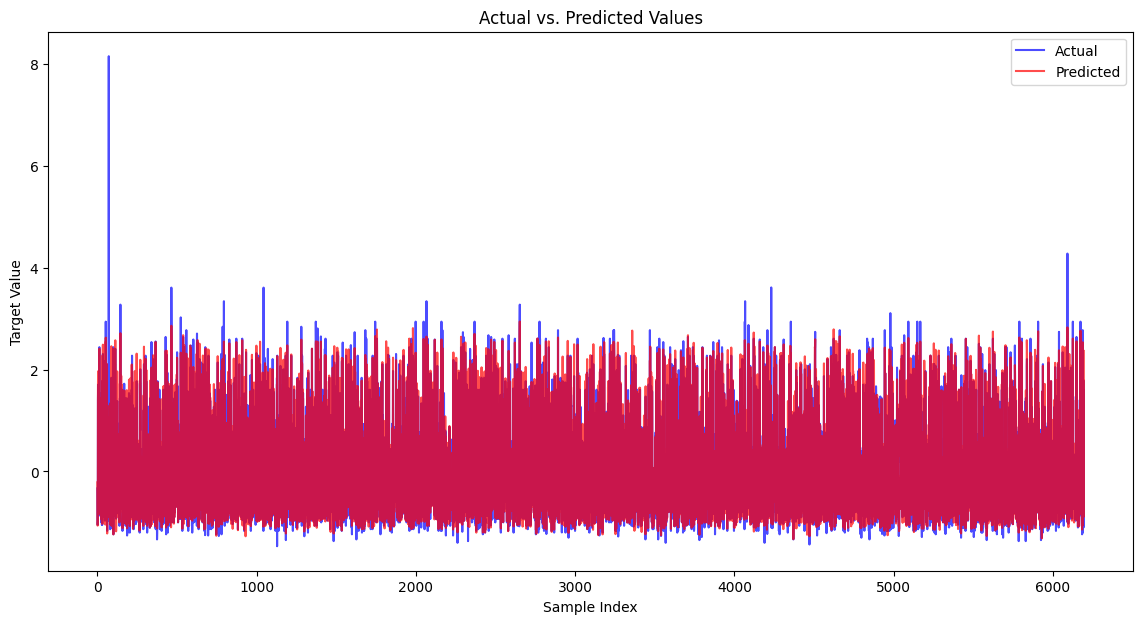

In [28]:
import matplotlib.pyplot as plt

# Generate predictions on the validation set
model.eval()
predictions = []
actual_values = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        
        predictions.append(y_pred.cpu().numpy())
        actual_values.append(y_batch.cpu().numpy())

# Flatten the lists of predictions and actual values
predictions = np.concatenate(predictions, axis=0)
actual_values = np.concatenate(actual_values, axis=0)

# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predictions)

# Print the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.1444
Mean Squared Error (MSE): 0.0614
Root Mean Squared Error (RMSE): 0.2478
R-squared (R²) Score: 0.9375


In [ ]:
import torch
import torch.nn as nn

class CNNTransformer(nn.Module):
    def __init__(self, feature_dim, d_model, num_heads, num_layers, dropout=0.1, cnn_kernel_size=3, cnn_out_channels=64):
        super(CNNTransformer, self).__init__()
        
        # CNN Layer for feature extraction
        self.cnn = nn.Conv1d(in_channels=feature_dim, out_channels=cnn_out_channels, kernel_size=cnn_kernel_size, stride=1, padding=cnn_kernel_size//2)
        
        # Linear layer to project CNN output to the model dimension
        self.cnn_projection = nn.Linear(cnn_out_channels, d_model)
        
        # Positional encoding for the sequence
        self.positional_encoding = nn.Parameter(torch.zeros(1, WINDOW_SIZE, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final output layer
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        # Change shape to (batch_size, feature_dim, window_size) for CNN
        src = src.permute(0, 2, 1)  # Rearrange to (batch_size, feature_dim, window_size)
        
        # Apply CNN (output shape: (batch_size, cnn_out_channels, window_size))
        cnn_out = self.cnn(src)
        
        # Change shape back to (batch_size, window_size, cnn_out_channels)
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # Project CNN output to model dimension
        cnn_out = self.cnn_projection(cnn_out)
        
        # Add positional encoding
        src = cnn_out + self.positional_encoding
        
        # Transformer encoder
        out = self.transformer(src)
        
        # Pooling (mean across the sequence)
        out = out.mean(dim=1)
        
        # Final output layer
        return self.fc_out(out).squeeze(-1)

# Model hyperparameters
FEATURE_DIM = df_final.shape[1]  # Exclude 'ds', keep the rest as features
D_MODEL = 128
NUM_HEADS = 4
NUM_LAYERS = 3
DROPOUT = 0.1
WINDOW_SIZE = 30

# Initialize model
model = CNNTransformer(
    feature_dim=FEATURE_DIM,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Save the model
torch.save(model.state_dict(), 'cnn_transformer_model.pth')

# Load and test the model
model.load_state_dict(torch.load('cnn_transformer_model.pth'))
model.eval()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the model and set it to evaluation mode
model.load_state_dict(torch.load('cnn_transformer_model.pth'))
model.eval()

# Test evaluation
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert to numpy arrays for metric calculations
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Values on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [ ]:
residuals = y_true - y_pred

plt.figure(figsize=(14, 7))
plt.scatter(range(len(residuals)), residuals, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals of Predictions on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.show()


In [ ]:
plt.figure(figsize=(14, 7))
plt.hist(y_pred, bins=30, alpha=0.7, label='Predicted Values')
plt.hist(y_true, bins=30, alpha=0.7, label='Actual Values')
plt.title('Histogram of Actual vs. Predicted Values')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2:.4f}")
